In [1]:
import scanpy as sc
import pandas as pd
import diffxpy.api as de
import numpy as np
import patsy
import pickle
import matplotlib.pyplot as plt
import seaborn as sb
import upsetplot as usp
from matplotlib import rcParams
from diffxpy.testing.det import DifferentialExpressionTestWald
import matplotlib.cm as cm
import matplotlib as mpl
from sklearn.preprocessing import minmax_scale
from anndata import AnnData
from sklearn.linear_model import LinearRegression, LogisticRegression
import meld
import graphtools
from sklearn.preprocessing import  OneHotEncoder

import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/data_exploration/')
import helper_diffxpy as hde
import importlib
importlib.reload(hde)
import helper_diffxpy as hde
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
import helper as h
import importlib
importlib.reload(h)
import helper as h

In [3]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'
path_gene_groups='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/moransi/sfintegrated/'
path_save='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/de/de_diseased_T1_NODelim_meld/'

In [4]:
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'

In [5]:
adata_b_rn=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad')

## Prepare data

### Subset data

In [6]:
adata_b_rn.shape

(102143, 30672)

Do not use low quality cluster. Use only NOD elimination study

In [7]:
studies=['NOD_elimination' ]
samples=adata_b_rn.obs.query('study in @studies').study_sample.unique().tolist()
print('N samples to use',len(samples))
print(samples)

N samples to use 9
['NOD_elimination_SRR7610300', 'NOD_elimination_SRR7610299', 'NOD_elimination_SRR7610303', 'NOD_elimination_SRR7610297', 'NOD_elimination_SRR7610298', 'NOD_elimination_SRR7610301', 'NOD_elimination_SRR7610295', 'NOD_elimination_SRR7610302', 'NOD_elimination_SRR7610296']


In [8]:
# Subset 
# Samples from the study
adata_b_rn_sub=adata_b_rn[adata_b_rn.obs.study_sample.isin(samples),:].copy()
# Clusters
adata_b_rn_sub=adata_b_rn_sub[ ~adata_b_rn_sub.obs['leiden_r1.5'].isin(['19','20']),
                          :].copy()
print(adata_b_rn_sub.shape)
print(adata_b_rn_sub.obs.study_sample_design.unique().tolist())
print(adata_b_rn_sub.obs['leiden_r1.5'].unique().tolist())

(3678, 30672)
['NOD_elimination_SRR7610300_14w', 'NOD_elimination_SRR7610299_14w', 'NOD_elimination_SRR7610303_16w', 'NOD_elimination_SRR7610297_8w', 'NOD_elimination_SRR7610298_14w', 'NOD_elimination_SRR7610301_16w', 'NOD_elimination_SRR7610295_8w', 'NOD_elimination_SRR7610302_16w', 'NOD_elimination_SRR7610296_8w']
['16', '1', '11', '8', '3', '12', '7', '2', '10', '14', '4', '9', '0', '6', '13', '17', '15', '5', '22', '21']


In [9]:
# recompute subsetted visualisation
sc.pp.neighbors(adata_b_rn_sub,n_pcs=0,use_rep='X_integrated')
sc.tl.umap(adata_b_rn_sub)

Trying to set attribute `.uns` of view, copying.


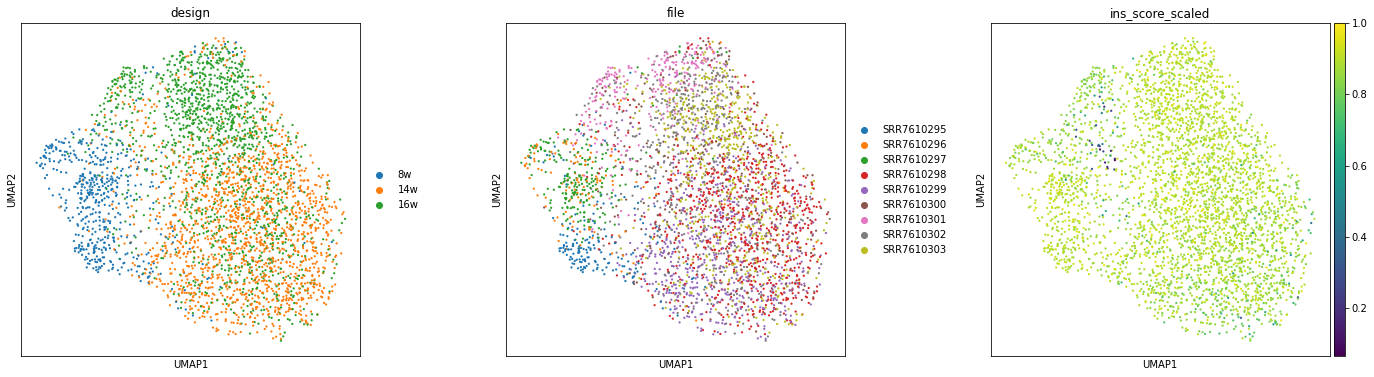

In [14]:
rcParams['figure.figsize']=(6,6)
random_indices=np.random.permutation(list(range(adata_b_rn_sub.shape[0])))
sc.pl.umap(adata_b_rn_sub[random_indices,:],
           color=['design','file','ins_score_scaled'],s=20,sort_order=False,wspace=0.3)

### MELD

In [34]:
# Prepare MELD object
meld_obj=meld.MELD()
meld_obj.X=adata_b_rn_sub.obsm['X_integrated']
# Make MELD graph
meld_obj=meld_obj.fit(graphtools.Graph(
    adata_b_rn_sub.obsp['connectivities'], precomputed="adjacency"))

In [35]:
# Make categories for meld - e.g. healthy or diseased per study, ignore treated (drop NA)
status_meld_map={
 'NOD_elimination_SRR7610295_8w':'healthy',
 'NOD_elimination_SRR7610296_8w':'healthy',
 'NOD_elimination_SRR7610297_8w':'healthy',
 'NOD_elimination_SRR7610298_14w':'diabetic',
 'NOD_elimination_SRR7610299_14w':'diabetic',
 'NOD_elimination_SRR7610300_14w':'diabetic',
 'NOD_elimination_SRR7610301_16w':'diabetic',
 'NOD_elimination_SRR7610302_16w':'diabetic',
 'NOD_elimination_SRR7610303_16w':'diabetic'}
status_meld=adata_b_rn_sub.obs.study_sample_design.map(status_meld_map).astype('category')
status_meld=pd.DataFrame(
    OneHotEncoder(categories=[status_meld.cat.categories.tolist()]).\
    fit_transform(np.array(status_meld).reshape(-1,1)).todense(),
    index=adata_b_rn_sub.obs_names,columns=status_meld.cat.categories.tolist()
    )

In [36]:
# Compute MELD
adata_b_rn_sub.obs.drop([col for col in adata_b_rn_sub.obs.columns if 'meld_' in col],
                       axis=1,inplace=True)
for col in status_meld.columns:
    adata_b_rn_sub.obs['meld_'+col+'_raw']=meld_obj.transform(status_meld[col])[1].values
# Normalize across healthy and diseased
adata_b_rn_sub.obs[
    [col.replace('_raw','') for col in adata_b_rn_sub.obs.columns if 'meld_' in col]]=\
    meld.utils.normalize_densities(
        adata_b_rn_sub.obs[[col for col in adata_b_rn_sub.obs.columns if 'meld_' in col]])

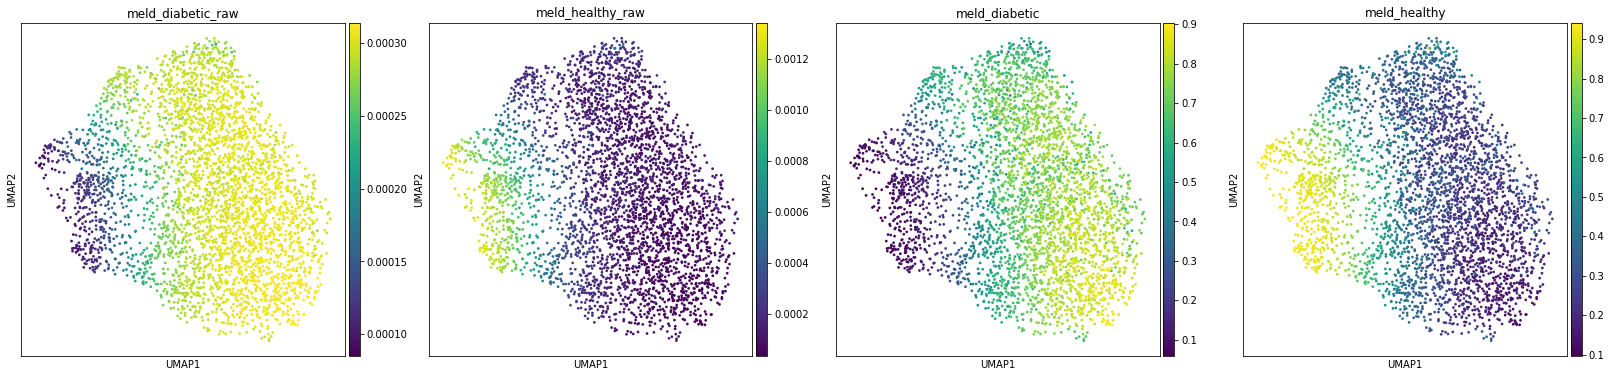

In [37]:
rcParams['figure.figsize']=(6,6)
sc.pl.umap(adata_b_rn_sub,color=[col for col in adata_b_rn_sub.obs.columns if 'meld_' in col],
          s=30)

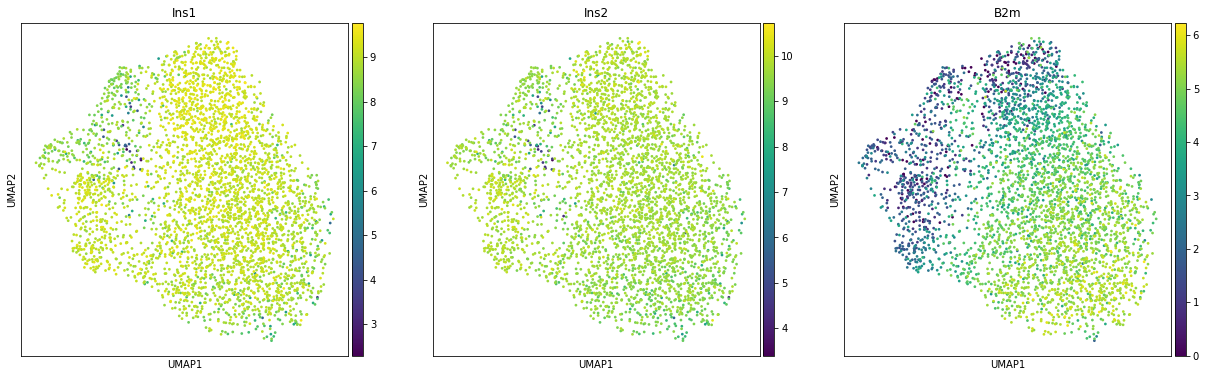

In [42]:
# Plot some markers for comparison
sc.pl.umap(adata_b_rn_sub,color=['Ins1','Ins2','B2m'],gene_symbols='gene_symbol',
          s=30)

C: As we do normalisation the healthy and diseased are mirror images of each other. The normalized score also corresponds more to B2m expression.

In [51]:
# Make MELD process for DE
# Scale process to [0,1] to be comparable with the T2D one
adata_b_rn_sub.obs['meld_process']=minmax_scale(adata_b_rn_sub.obs['meld_healthy']*-1)

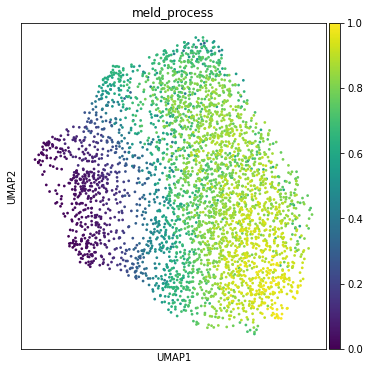

In [52]:
rcParams['figure.figsize']=(6,6)
sc.pl.umap(adata_b_rn_sub,color='meld_process', s=30)

In [53]:
# Save meld process
pd.DataFrame(adata_b_rn_sub.obs['meld_process'],
                index=adata_b_rn_sub.obs_names,
                columns=['meld_process']).to_csv(path_save+'process_MELD.tsv',sep='\t')

#### Plot of design info

In [10]:
# reload meld
#adata_b_rn_sub.obs['meld_process']=pd.read_table(
#    path_save+'process_MELD.tsv',index_col=0)['meld_process']

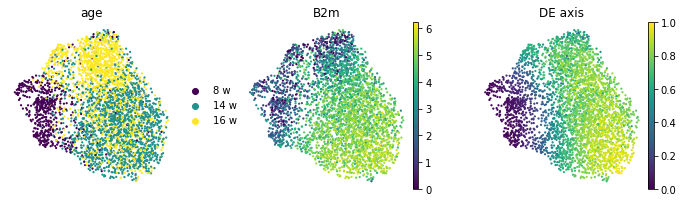

In [29]:
# Plot 
rcParams['figure.figsize']=(3,3)
np.random.seed(0)
random_indices=list(np.random.permutation(list(adata_b_rn_sub.obs_names)))
adata_b_rn_sub.obs['age']=pd.Categorical(
    values=adata_b_rn_sub.obs['age'],categories=['8 w','14 w','16 w'],ordered=True)
adata_b_rn_sub.uns['age_colors']=['#440154','#21918c','#fde725']
g=sc.pl.umap(adata_b_rn_sub[random_indices,:],color=['age','B2m','meld_process'],
           gene_symbols='gene_symbol',sort_order=False,
           s=20,show=False,frameon=False)
for ax in g:
    if ax.get_title()=='meld_process':
        ax.set_title('DE axis')
plt.savefig(path_fig+'umap_beta_NODelim_DEdesign.png',dpi=300,bbox_inches='tight')

## DE test

In [54]:
# Get raw expression data for DE testing, subsetting by cells
adata_b_raw_sub=sc.read( path_data+'data_integrated_analysed_beta_v1s1.h5ad'
    ).raw.to_adata()[ adata_b_rn_sub.obs_names,:].copy()
print(adata_b_raw_sub.shape)

(3678, 30672)


In [60]:
# Add obs info for testing to raw
adata_b_raw_sub.obs=adata_b_rn_sub.obs[['size_factors_integrated','meld_process',
                                        'study_sample_design']].copy()
adata_b_raw_sub.obs['status_meld']=adata_b_raw_sub.obs.study_sample_design.map(status_meld_map)

Expression filtering of genes - keep genes that are expressed in either healthy or diseased groups used for MELD

In [8]:
min_cells_ratio=0.05

In [75]:
# prepare adata
# Data for testing
adata=adata_b_raw_sub.copy()
# Select expressed genes in partition
cells_healthy=adata.obs.query('status_meld=="healthy"').index
cells_diabetic=adata.obs.query('status_meld=="diabetic"').index
expressed=np.array((adata[cells_healthy,:].X.todense()>0).sum(axis=0)>=
         cells_healthy.shape[0]*min_cells_ratio).ravel()|\
       np.array((adata[cells_diabetic,:].X.todense()>0).sum(axis=0)>=
         cells_diabetic.shape[0]*min_cells_ratio).ravel()
adata=adata[:,expressed]
print('Data after expression filtering:',adata.shape)

Data after expression filtering: (3678, 9839)


### Design and DE

In [76]:
dmat_loc=pd.DataFrame(index=adata.obs_names)
dmat_loc['Intercept']=1

#process of interest
process='meld_process'
dmat_loc[process]=adata.obs[process]
        
dmat_loc=dmat_loc.astype('float')

print('dmat_loc')
display(dmat_loc)

dmat_scale=pd.DataFrame(dmat_loc['Intercept'])
constraints_scale=None
constraints_loc=None

coef_to_test=process

dmat_loc


Intercept  meld_process
AAACGGGAGCTCAACT-1-SRR7610300-NOD_elimination        1.0      0.654151
AAAGCAATCGCTAGCG-1-SRR7610300-NOD_elimination        1.0      0.827846
AAATGCCCAAAGCAAT-1-SRR7610300-NOD_elimination        1.0      0.902836
AAATGCCCATCGATTG-1-SRR7610300-NOD_elimination        1.0      0.680524
AAATGCCTCAAACAAG-1-SRR7610300-NOD_elimination        1.0      0.882044
...                                                  ...           ...
TTCTCCTGTCCGTTAA-1-SRR7610296-NOD_elimination        1.0      0.094753
TTCTTAGTCCGCATCT-1-SRR7610296-NOD_elimination        1.0      0.177824
TTGACTTCAATTGCTG-1-SRR7610296-NOD_elimination        1.0      0.018174
TTGGAACGTGTGACGA-1-SRR7610296-NOD_elimination        1.0      0.024599
TTTACTGTCCTCAACC-1-SRR7610296-NOD_elimination        1.0      0.056022

[3678 rows x 2 columns]

In [77]:
if True:
    # Compute result
    result=de.test.wald(
        data=adata,
        coef_to_test=coef_to_test,
        dmat_loc=dmat_loc,
        dmat_scale=dmat_scale,
        constraints_loc=constraints_loc,
        constraints_scale=constraints_scale,
        # Use integarted sf
        size_factors=adata.obs.size_factors_integrated
        )

    # Add design info to result
    result.dmat_loc=dmat_loc
    result.dmat_scale=dmat_scale
    result.constraints_loc=constraints_loc
    result.constraints_scale=constraints_scale
    result.coef_loc_totest_name=coef_to_test

    # save result
    pickle.dump(result, 
        open(path_save+'healthyDiseased_minCellsRatio'+str(min_cells_ratio)+'.pkl', 
                     "wb" ))

training location model: True
training scale model: True
iter   0: ll=35714738.419933
iter   1: ll=29174465.788244, converged: 0.00% (loc: 0.00%, scale update: False), in 4.76sec
iter   2: ll=28157753.378586, converged: 0.00% (loc: 0.00%, scale update: False), in 3.47sec
iter   3: ll=28123818.039607, converged: 0.00% (loc: 0.00%, scale update: False), in 3.73sec
iter   4: ll=28123407.129468, converged: 0.00% (loc: 0.00%, scale update: False), in 3.49sec
iter   5: ll=28123397.891500, converged: 0.00% (loc: 64.69%, scale update: False), in 3.48sec
iter   6: ll=27479118.597428, converged: 0.00% (loc: 0.00%, scale update: True), in 68.33sec
iter   7: ll=27478588.765912, converged: 0.00% (loc: 1.73%, scale update: False), in 3.52sec
iter   8: ll=27478587.746470, converged: 0.00% (loc: 23.09%, scale update: False), in 3.40sec
iter   9: ll=27478587.724003, converged: 0.00% (loc: 97.41%, scale update: False), in 3.13sec
iter  10: ll=27478587.719457, converged: 0.00% (loc: 99.58%, scale update:

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/dask/array/core.py:2894: RuntimeWarning: divide by zero encountered in true_divide
  size = (limit / dtype.itemsize / largest_block) ** (1 / len(autos))


NameError: name 'path_save_meld_covarpc' is not defined

## Analyse DE data

In [9]:
# Loada data
result=pickle.load(
    open(path_save+'healthyDiseased_minCellsRatio'+str(min_cells_ratio)+'.pkl','rb'))

summary=result.summary()
summary.index=summary.gene

### DE result vs gene expression information

In [80]:
# Empirical lFC
c2=np.argmax(adata_b_rn_sub.obs['meld_process'])
c1=np.argmin(adata_b_rn_sub.obs['meld_process'])
result.empirical_log2fc=pd.Series(np.asarray(np.log2(
     (adata_b_rn_sub[c2,summary.gene].X/
    adata_b_rn_sub[c2,summary.gene].obs['size_factors_integrated'].values)/
     (adata_b_rn_sub[c1,summary.gene].X/
      adata_b_rn_sub[c1,summary.gene].obs['size_factors_integrated'].values)
    )).ravel(), index=summary.gene).replace(np.inf,np.nan)

<ipython-input-80-b6b65281d132>:4: RuntimeWarning: divide by zero encountered in true_divide
  (adata_b_rn_sub[c2,summary.gene].X/
<ipython-input-80-b6b65281d132>:4: RuntimeWarning: invalid value encountered in true_divide
  (adata_b_rn_sub[c2,summary.gene].X/
<ipython-input-80-b6b65281d132>:3: RuntimeWarning: divide by zero encountered in log2
  result.empirical_log2fc=pd.Series(np.asarray(np.log2(


In [81]:
# Expression strength
n_cells=pd.Series(np.asarray((adata_b_rn_sub.X.todense()!=0).sum(axis=0)).ravel(),
                  index=adata_b_rn_sub.var_names)
mean_expr_in_expr_cells=pd.Series(np.asarray(
    adata_b_rn_sub[result.dmat_loc.index].X.sum(axis=0)
          ).ravel(),index=adata_b_rn_sub.var_names)/n_cells

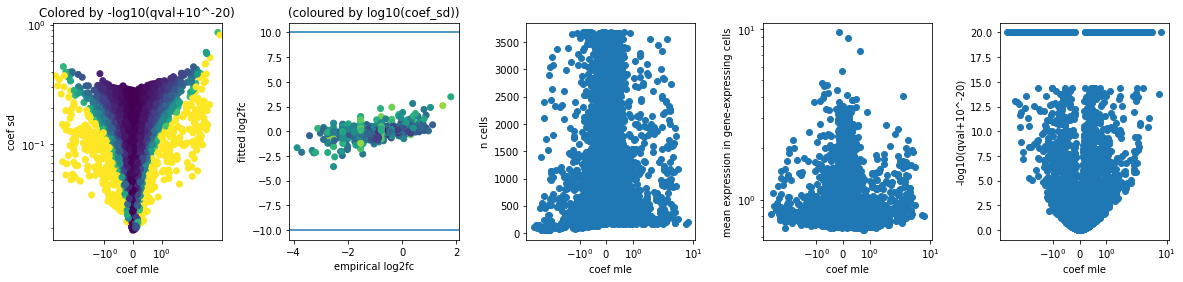

Min coef_sd: 0.019128173882604703


In [82]:
# Compare DE results of individual genes and expression characteristics
fig,ax=plt.subplots(1,5,figsize=(20,4))
plt.subplots_adjust(wspace=0.4)

ax[0].scatter(summary.coef_mle,summary.coef_sd,c=-np.log10(summary.qval+10**-20))
ax[0].set_xlabel('coef mle')
ax[0].set_ylabel('coef sd')
ax[0].set_yscale('log')
ax[0].set_xscale('symlog')
ax[0].set_title('Colored by -log10(qval+10^-20)')

ax[4].scatter(summary.coef_mle,-np.log10(summary.qval+10**(-20)))
ax[4].set_xlabel('coef mle')
ax[4].set_ylabel('-log10(qval+10^-20)')
ax[4].set_xscale('symlog')

if 'empirical_log2fc' in dir(result):
    ax[1].set_title('(coloured by log10(coef_sd))')
    # genes with nan empirical lfc will not be shown
    ax[1].scatter(x=result.empirical_log2fc.values,y=summary.log2fc,
                c=np.log10(summary.coef_sd))
    ax[1].set_xlabel('empirical log2fc')
    ax[1].set_ylabel('fitted log2fc')
    #ax[1].set_yscale('symlog')
    ax[1].axhline(10)
    ax[1].axhline(-10)

ax[2].scatter(summary.coef_mle,n_cells[summary.gene])
ax[2].set_xlabel('coef mle')
ax[2].set_ylabel('n cells')
ax[2].set_xscale('symlog')

ax[3].scatter(summary.coef_mle,mean_expr_in_expr_cells[summary.gene])
ax[3].set_xlabel('coef mle')
ax[3].set_ylabel('mean expression in gene-expressing cells')
ax[3].set_xscale('symlog')
ax[3].set_yscale('log')

display(fig)
plt.close()
print('Min coef_sd:',summary.coef_sd.min())

In [83]:
print('Min coef_sd:',summary.coef_sd.min())
#Min coef_sd: 0.019128173882604703

Min coef_sd: 0.019128173882604703


C: All genes could be fitted with a reasonable SD

In [13]:
# Add gene symbols as index
summary['EID']=summary.index
summary.index=adata_b_rn_sub.var.loc[summary.index,'gene_symbol']

In [14]:
# Save summary table for sharing
if True:
    summary.to_csv(
        path_save+'healthyDiseased_minCellsRatio'+str(min_cells_ratio)+'_summary.tsv',
    sep='\t')

### Check top genes

Expected DE genes

In [86]:
# Expected DE gene
summary.loc['B2m',:]

gene         ENSMUSG00000060802
pval                        0.0
qval                        0.0
log2fc                 2.804964
mean                   89.53453
zero_mean                 False
grad                        0.0
coef_mle               2.804964
coef_sd                0.059899
ll                -19330.320787
EID          ENSMUSG00000060802
Name: B2m, dtype: object

Expression of top DE genes

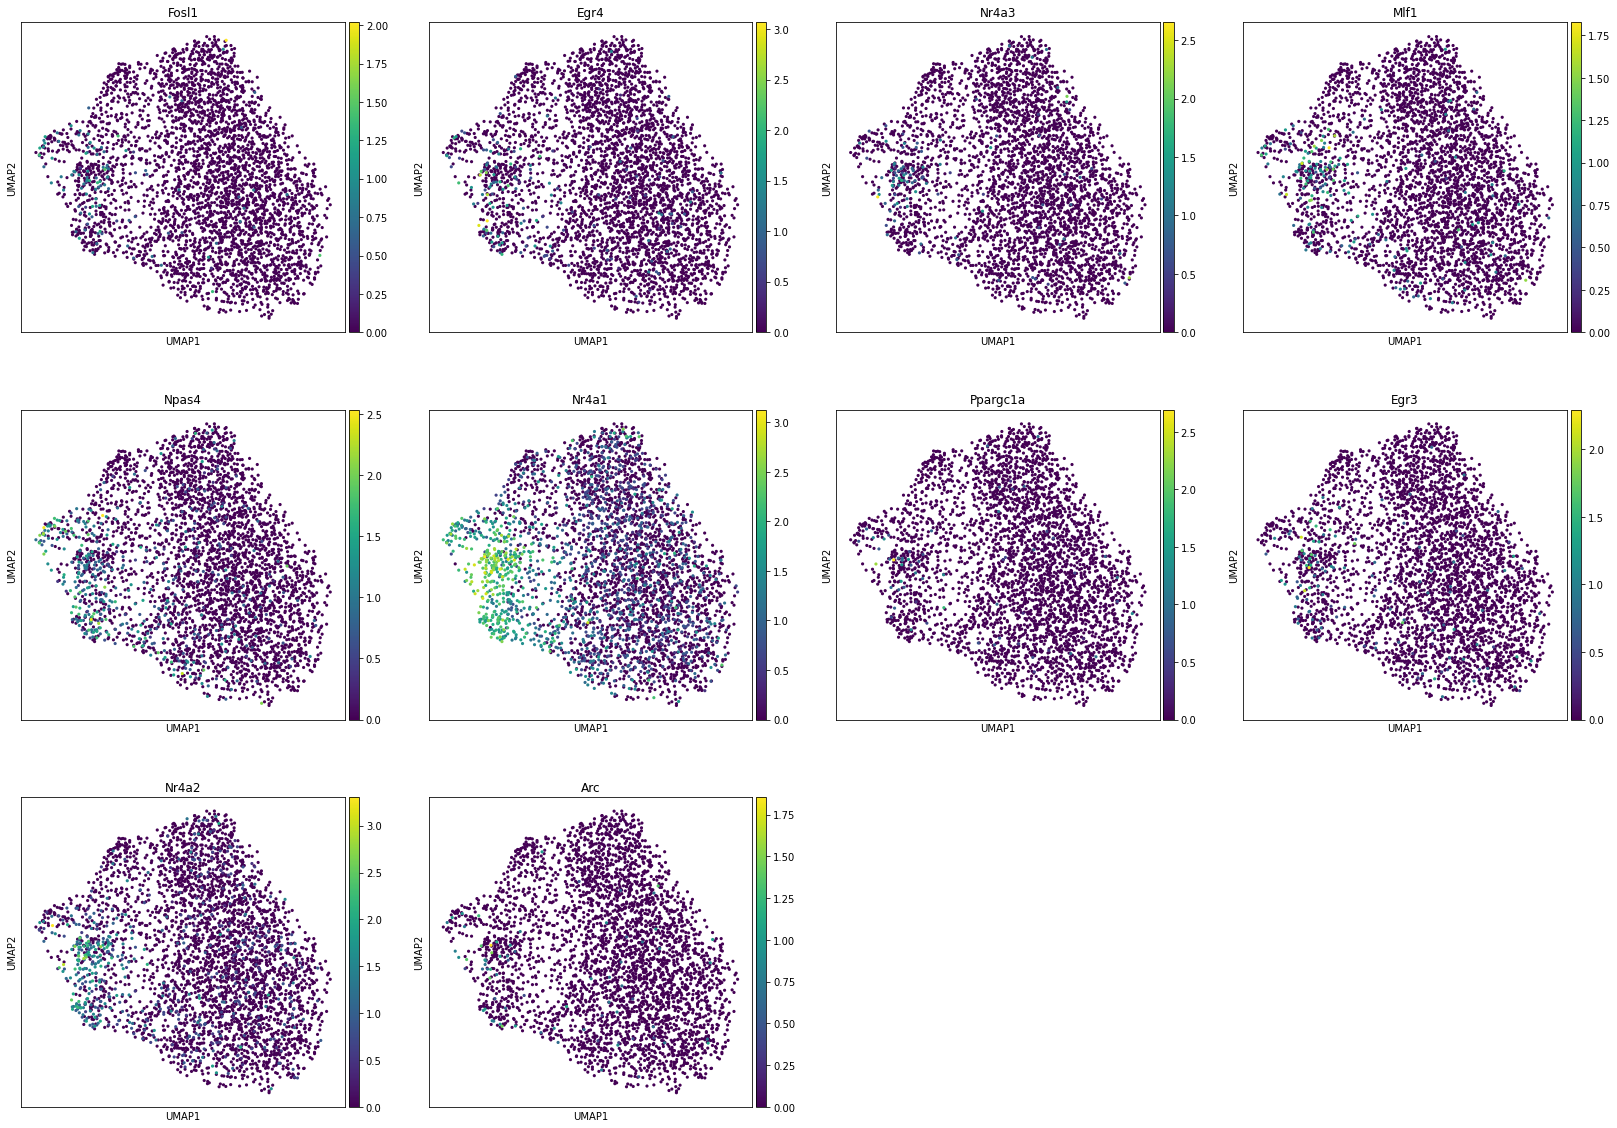

In [91]:
rcParams['figure.figsize']=(6,6)
sc.pl.umap(adata_b_rn_sub,
           color=summary.sort_values(['coef_mle']).index[:10],gene_symbols='gene_symbol',
           s=40)

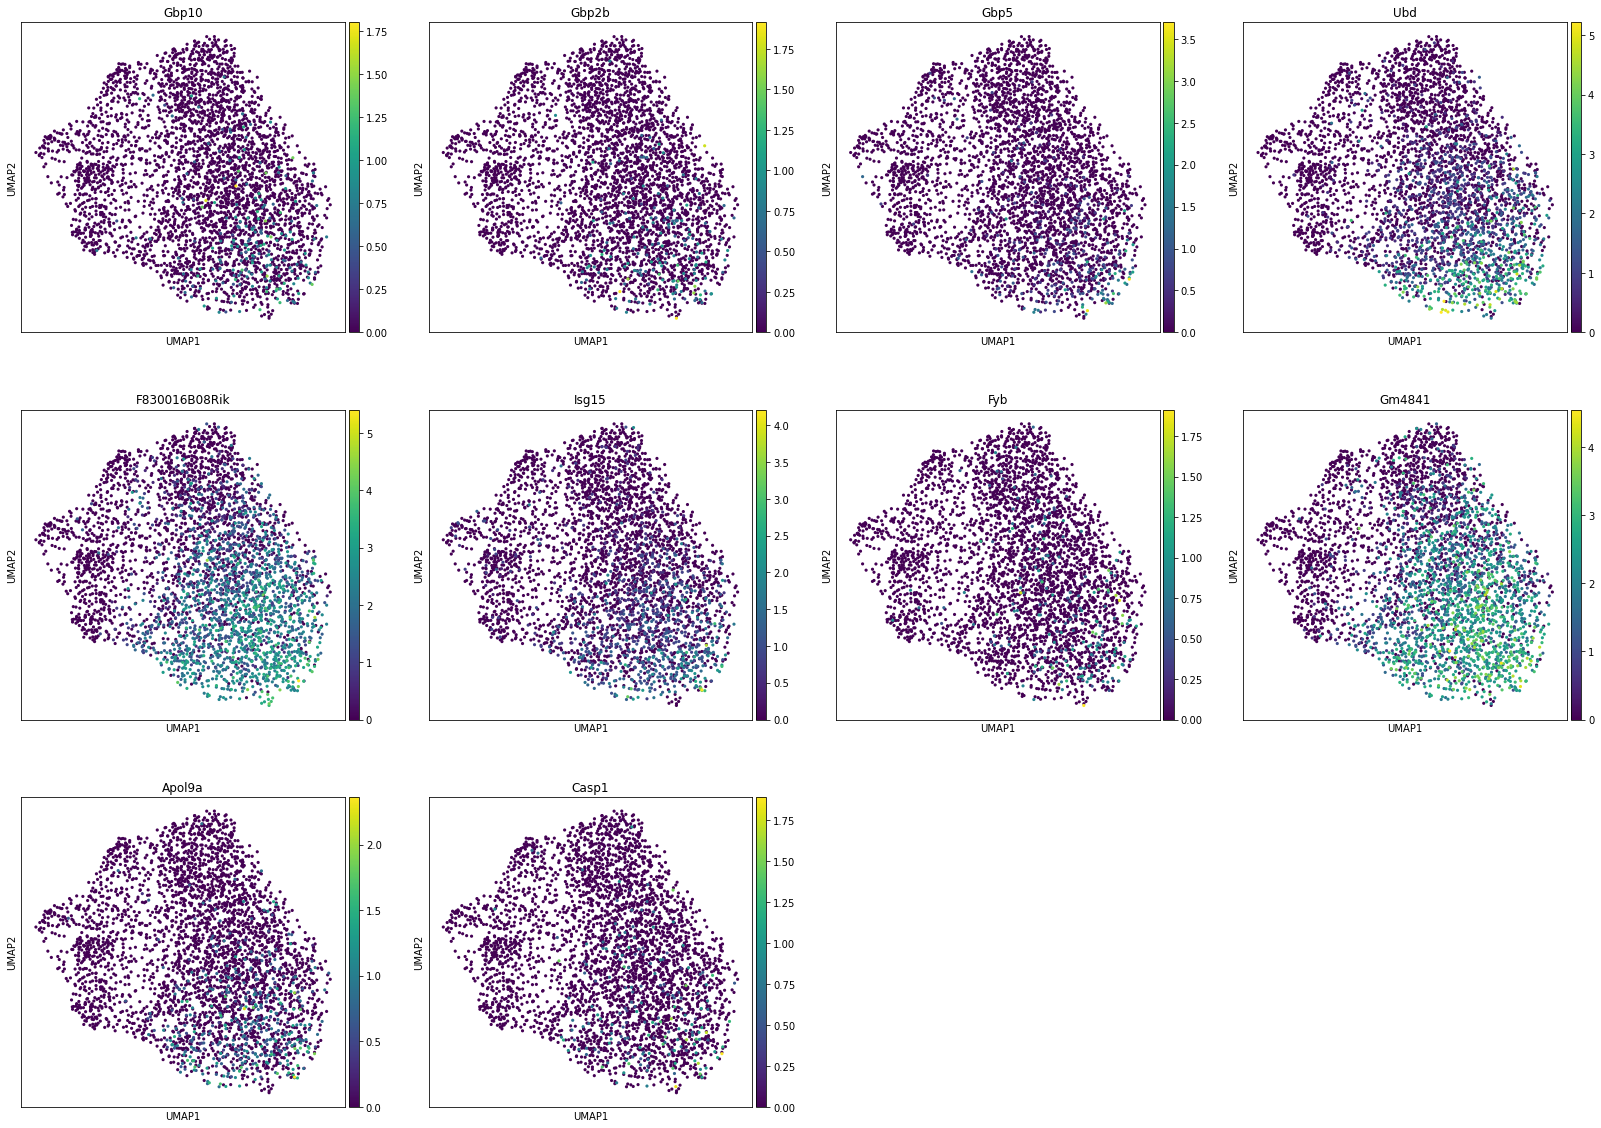

In [92]:
rcParams['figure.figsize']=(6,6)
sc.pl.umap(adata_b_rn_sub,
           color=summary.sort_values(
               ['coef_mle'],ascending=[False]).index[:10],gene_symbols='gene_symbol',
           s=40)

C: There is clear preference for top DE genes to be up in 14w, but this is also coresponding to the embedding.

### N DE genes

N DE genes at different thresholds

In [93]:
for fdr,lfc in [(0.05,1),(0.05,2),(0.01,1.5),(0.01,2),(0.01,2.5),(0.01,3),(0.01,4),(0.001,2),(10**-19,2)]:
    print('fdr %.2e, abs(lfc) > %.1f up %i down %i'%
          (fdr,lfc,summary.query('qval<@fdr & log2fc>@lfc').shape[0],
           summary.query('qval<@fdr & log2fc<-@lfc').shape[0]))

fdr 5.00e-02, abs(lfc) > 1.0 up 284 down 228
fdr 5.00e-02, abs(lfc) > 2.0 up 97 down 53
fdr 1.00e-02, abs(lfc) > 1.5 up 152 down 106
fdr 1.00e-02, abs(lfc) > 2.0 up 97 down 53
fdr 1.00e-02, abs(lfc) > 2.5 up 62 down 27
fdr 1.00e-02, abs(lfc) > 3.0 up 40 down 15
fdr 1.00e-02, abs(lfc) > 4.0 up 12 down 3
fdr 1.00e-03, abs(lfc) > 2.0 up 97 down 53
fdr 1.00e-19, abs(lfc) > 2.0 up 71 down 42


C: All genes with high lfc are significant.

LFC distn

Text(0.5, 0, 'log2fc')

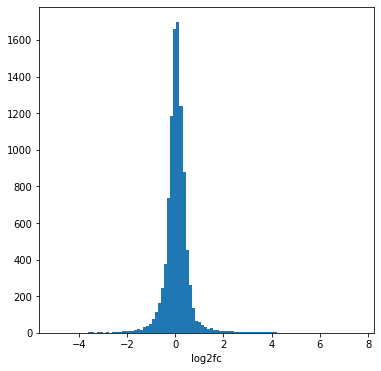

In [94]:
# LFC distn
plt.hist(summary.log2fc,bins=100)
plt.xlabel('log2fc')